In [36]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model,Model
from keras.layers import Dense, Dropout, LSTM,Input,Concatenate,GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

In [8]:
# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0


In [74]:
# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [75]:
train_df = train_df.sort_values(['id','cycle'])

In [76]:
# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [77]:
# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [78]:
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

In [79]:
# generate label columns for training data
# we will only make use of "label1" for binary classification, 
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

In [80]:
# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

In [81]:
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

   id  cycle  setting1  setting2  setting3   s1        s2  ...  s16       s17  s18  s19       s20       s21  cycle_norm
0   1      1  0.632184  0.750000       0.0  0.0  0.545181  ...  0.0  0.333333  0.0  0.0  0.558140  0.661834     0.00000
1   1      2  0.344828  0.250000       0.0  0.0  0.150602  ...  0.0  0.416667  0.0  0.0  0.682171  0.686827     0.00277
2   1      3  0.517241  0.583333       0.0  0.0  0.376506  ...  0.0  0.416667  0.0  0.0  0.728682  0.721348     0.00554
3   1      4  0.741379  0.500000       0.0  0.0  0.370482  ...  0.0  0.250000  0.0  0.0  0.666667  0.662110     0.00831
4   1      5  0.580460  0.500000       0.0  0.0  0.391566  ...  0.0  0.166667  0.0  0.0  0.658915  0.716377     0.01108

[5 rows x 27 columns]


In [82]:
# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [83]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

In [84]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

In [85]:
# pick a large window size of 50 cycles
sequence_length = 50

In [86]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

In [87]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [88]:
# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

In [89]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

(15631, 50, 25)


In [90]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

In [91]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

In [92]:
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

In [99]:
def best_model():
    input1 = Input(shape=(sequence_length,nb_features),name='input1',dtype='float32')
    input2 = Input(shape=(sequence_length,nb_features),name='input2',dtype='float32')
    print(input1.shape)
    print(input2.shape)
    lstm1 = LSTM(units=200, return_sequences=True)(input1)
    lstm1 = Dropout(0.2)(lstm1)
    lstm1 = LSTM(units=100, return_sequences=True)(lstm1)
    lstm1 = Dropout(0.2)(lstm1)
    lstm1 = LSTM(units=50, return_sequences=False)(lstm1)
    lstm1 = Dropout(0.2)(lstm1)
    
    lstm2 = GRU(units=200, return_sequences=True)(input2)
    lstm2 = Dropout(0.2)(lstm2)
    lstm2 = GRU(units=100, return_sequences=True)(lstm2)
    lstm2 = Dropout(0.2)(lstm2)
    lstm2 = GRU(units=50, return_sequences=False)(lstm2)
    lstm2 = Dropout(0.2)(lstm2)
    
    comb = Concatenate(axis=1)([lstm1,lstm2])
    pred = Dense(units=nb_out, activation='linear', name='output')(comb)
    model = Model(inputs=[input1,input2], outputs=pred)
    model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

    return model

In [100]:
model = best_model()
model.summary()

(None, 50, 25)
(None, 50, 25)
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 50, 25)       0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 50, 25)       0                                            
__________________________________________________________________________________________________
lstm_24 (LSTM)                  (None, 50, 200)      180800      input1[0][0]                     
__________________________________________________________________________________________________
gru_19 (GRU)                    (None, 50, 200)      135600      input2[0][0]                     
______________________________________________________________

In [95]:
filepath="weights.regression1.hdf5"
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10,min_delta=0)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto')

In [101]:
# fit the network
history = model.fit([seq_array,seq_array], label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [early_stop,checkpoint]
          )

# list all data in history
print(history.history.keys())

Train on 14849 samples, validate on 782 samples
Epoch 1/100
 - 113s - loss: 8008.6412 - mae: 70.4675 - r2_keras: -1.4641e+00 - val_loss: 7184.6759 - val_mae: 66.2355 - val_r2_keras: -1.9697e+00
Epoch 2/100
 - 108s - loss: 6894.9055 - mae: 64.1376 - r2_keras: -1.1237e+00 - val_loss: 6291.4653 - val_mae: 61.1287 - val_r2_keras: -1.5572e+00
Epoch 3/100
 - 109s - loss: 6060.1527 - mae: 59.4452 - r2_keras: -8.6024e-01 - val_loss: 5518.6044 - val_mae: 56.7863 - val_r2_keras: -1.2087e+00
Epoch 4/100
 - 109s - loss: 5329.4820 - mae: 55.4188 - r2_keras: -6.3651e-01 - val_loss: 4856.2410 - val_mae: 53.1475 - val_r2_keras: -9.1940e-01
Epoch 5/100
 - 111s - loss: 4720.4037 - mae: 52.1500 - r2_keras: -4.5175e-01 - val_loss: 4305.7194 - val_mae: 50.2229 - val_r2_keras: -6.8992e-01
Epoch 6/100
 - 111s - loss: 4220.0692 - mae: 49.6003 - r2_keras: -2.9349e-01 - val_loss: 3868.9090 - val_mae: 48.0164 - val_r2_keras: -5.2062e-01
Epoch 7/100
 - 111s - loss: 3837.9284 - mae: 47.7854 - r2_keras: -1.7759e-01

In [102]:
model.load_weights("weights.regression1.hdf5")
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

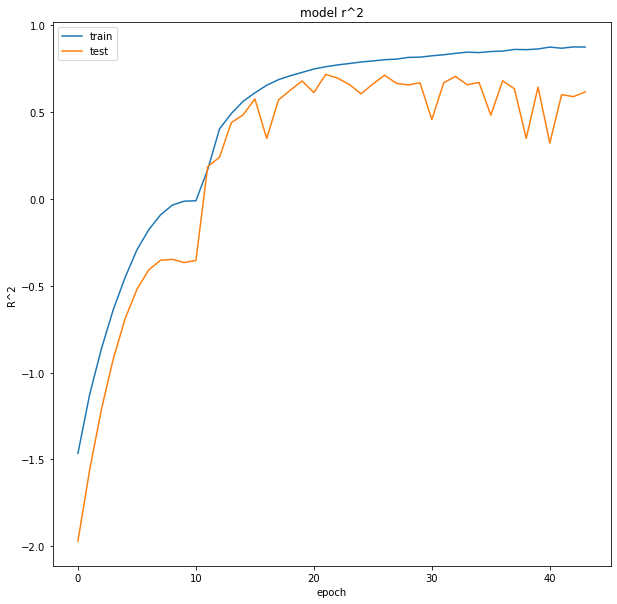

In [103]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

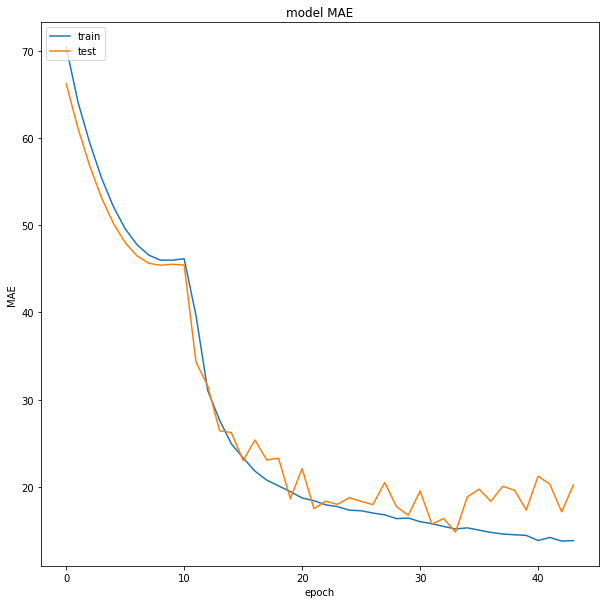

In [104]:
# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

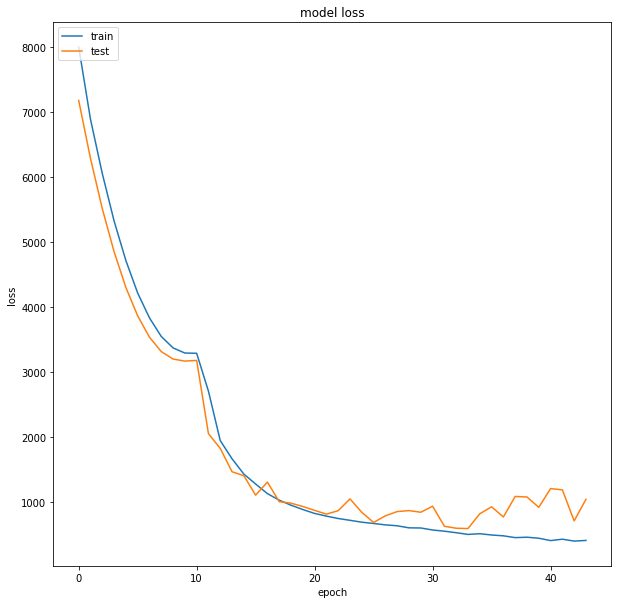

In [105]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [107]:
# training metrics
scores = model.evaluate([seq_array,seq_array], label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

15631/15631 [==============================] - 26s 2ms/step

MAE: 14.56912899017334

R^2: 0.8014203906059265


In [108]:
y_pred = model.predict([seq_array,seq_array],verbose=1, batch_size=200)
y_true = label_array

15631/15631 [==============================] - 25s 2ms/step


In [109]:
# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print("seq_array_test_last")
#print(seq_array_test_last)
print(seq_array_test_last.shape)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)
print("label_array_test_last")
print(label_array_test_last)


seq_array_test_last
(93, 50, 25)
(93, 1)
label_array_test_last
[[ 69.]
 [ 82.]
 [ 91.]
 [ 93.]
 [ 91.]
 [ 95.]
 [111.]
 [ 96.]
 [ 97.]
 [124.]
 [ 95.]
 [ 83.]
 [ 84.]
 [ 50.]
 [ 28.]
 [ 87.]
 [ 16.]
 [ 57.]
 [113.]
 [ 20.]
 [119.]
 [ 66.]
 [ 97.]
 [ 90.]
 [115.]
 [  8.]
 [ 48.]
 [106.]
 [  7.]
 [ 11.]
 [ 19.]
 [ 21.]
 [ 50.]
 [ 28.]
 [ 18.]
 [ 10.]
 [ 59.]
 [109.]
 [114.]
 [ 47.]
 [135.]
 [ 92.]
 [ 21.]
 [ 79.]
 [114.]
 [ 29.]
 [ 26.]
 [ 97.]
 [137.]
 [ 15.]
 [103.]
 [ 37.]
 [114.]
 [100.]
 [ 21.]
 [ 54.]
 [ 72.]
 [ 28.]
 [128.]
 [ 14.]
 [ 77.]
 [  8.]
 [121.]
 [ 94.]
 [118.]
 [ 50.]
 [131.]
 [126.]
 [113.]
 [ 10.]
 [ 34.]
 [107.]
 [ 63.]
 [ 90.]
 [  8.]
 [  9.]
 [137.]
 [ 58.]
 [ 89.]
 [116.]
 [115.]
 [136.]
 [ 28.]
 [ 38.]
 [ 20.]
 [ 85.]
 [ 55.]
 [128.]
 [137.]
 [ 82.]
 [ 59.]
 [117.]
 [ 20.]]


In [110]:
# test metrics
scores_test = model.evaluate([seq_array_test_last,seq_array_test_last], label_array_test_last, verbose=2)
print('\nMAE: {}'.format(scores_test[1]))
print('\nR^2: {}'.format(scores_test[2]))


MAE: 13.144071578979492

R^2: 0.760365903377533
